# 06-trees hw

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv

--2025-10-30 12:53:04--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874188 (854K) [text/plain]
Saving to: ‘car_fuel_efficiency.csv’

car_fuel_efficiency 100%[===================>] 853,70K  --.-KB/s    in 0,05s   

2025-10-30 12:53:05 (15,9 MB/s) - ‘car_fuel_efficiency.csv’ saved [874188/874188]



In [4]:
df = pd.read_csv("car_fuel_efficiency.csv")
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


### Data preparation

In [5]:
df.isnull().sum()

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64

In [10]:
df.fillna(0, inplace=True)

In [11]:
df.isnull().sum()

engine_displacement    0
num_cylinders          0
horsepower             0
vehicle_weight         0
acceleration           0
model_year             0
origin                 0
fuel_type              0
drivetrain             0
num_doors              0
fuel_efficiency_mpg    0
dtype: int64

### Split the data

In [30]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [31]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# turn target value into binary
y_train = df_train.fuel_efficiency_mpg.astype('int').values
y_val = df_val.fuel_efficiency_mpg.astype('int').values
y_test = df_test.fuel_efficiency_mpg.astype('int').values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [17]:
df_train.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors
0,120,5.0,169.0,2966.679505,13.9,2005,USA,Gasoline,Front-wheel drive,-1.0
1,200,3.0,143.0,2950.822121,17.1,2013,Asia,Diesel,Front-wheel drive,-1.0
2,180,6.0,180.0,3078.221669,17.4,2007,USA,Gasoline,All-wheel drive,0.0
3,280,5.0,174.0,2797.991793,0.0,2016,USA,Diesel,All-wheel drive,0.0
4,250,4.0,133.0,2362.426930,16.3,2010,USA,Diesel,Front-wheel drive,-1.0


In [40]:
y_val

array([18, 15, 18, ..., 14, 13, 16], shape=(1941,))

#### Q1 Decision tree

In [21]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [20]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)

In [23]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [24]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- vehicle_weight <= 3000.14
|   |--- value: [16.44]
|--- vehicle_weight >  3000.14
|   |--- value: [12.51]



#### Q2

In [43]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [45]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_pred = rf.predict(X_val)
y_pred


array([17.9, 14.8, 17.9, ..., 13.9, 12.5, 15.5], shape=(1941,))

In [47]:
from sklearn.metrics import root_mean_squared_error
root_mean_squared_error(y_val, y_pred)

0.5521537615591471

#### Q3

In [48]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)

    scores.append((n, rmse))

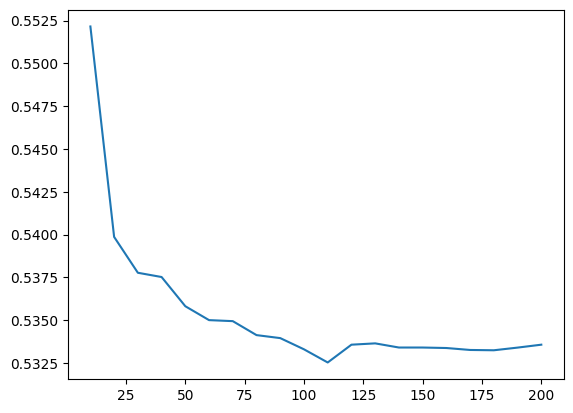

In [49]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
df_scores.head()
plt.plot(df_scores.n_estimators, df_scores.rmse)

#### Q4

In [50]:
max_depth = [10, 15, 20, 25]

for d in max_depth:
    scores = []

    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)

        scores.append(rmse)

    print(f"max_depth={d}", f"mean RMSE: {np.mean(scores)}")

max_depth=10 mean RMSE: 0.5290300875129883
max_depth=15 mean RMSE: 0.5356500040733679
max_depth=20 mean RMSE: 0.5357163798180502
max_depth=25 mean RMSE: 0.5353907339303252


#### Q5

In [69]:
X_train[:,1]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2934 stored elements and shape (5822, 1)>

In [81]:
feature_names = [f"feature {dv.get_feature_names_out()[i]}" for i in range(X_train.shape[1])]
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=1)
rf.fit(X_train, y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [82]:
importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)

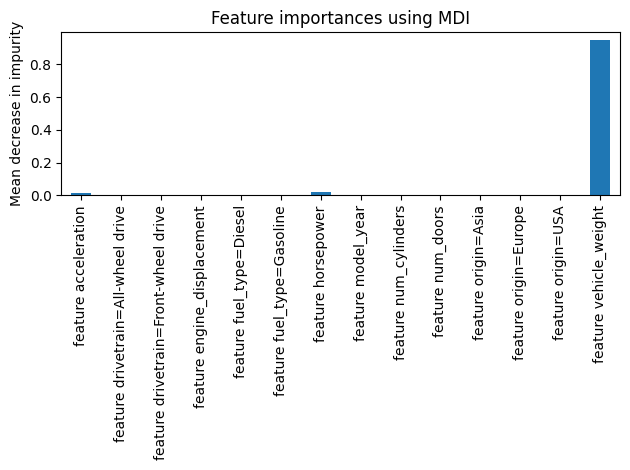

In [83]:
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Q6

In [97]:
import xgboost as xgb
from IPython.display import display

In [109]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [85]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [100]:
scores = {}
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [113]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [114]:
df_score = parse_xgb_output(output)
df_score.head()

,num_iter,train_rmse,val_rmse
0,0,2.30044,2.36010
1,5,1.43553,1.47393
2,10,0.94819,0.98170
3,15,0.68886,0.72621
4,20,0.55795,0.60541


In [115]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = np.mean(df_score.val_rmse)

In [116]:
scores

{'eta=0.3': np.float64(0.607007142857143),
 'eta=0.1': np.float64(0.6910033333333334)}